In [83]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [84]:
rootfolder = '../'

Load the image and rescale it in $[0,1]$

In [85]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255
img = img[50:200, 50:200]
imsz = img.shape

# patch size
p = 7

# number of elements in the patch
M = p ** 2

# radius of the search neighborhood
H = 12


Corrupt the image with white gaussian noise

In [86]:
sigma_noise = 20/255
noisy_img = img + sigma_noise * np.random.rand(*img.shape)

Compute the PSNR of the noisy input

In [87]:
def psnr(img1, img2, max_pixel=1.0):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(max_pixel ** 2 / mse)

In [88]:
psnr_noisy = psnr(img, noisy_img)


Text(0.5, 1.0, 'Noisy image, PSNR = 26.88')

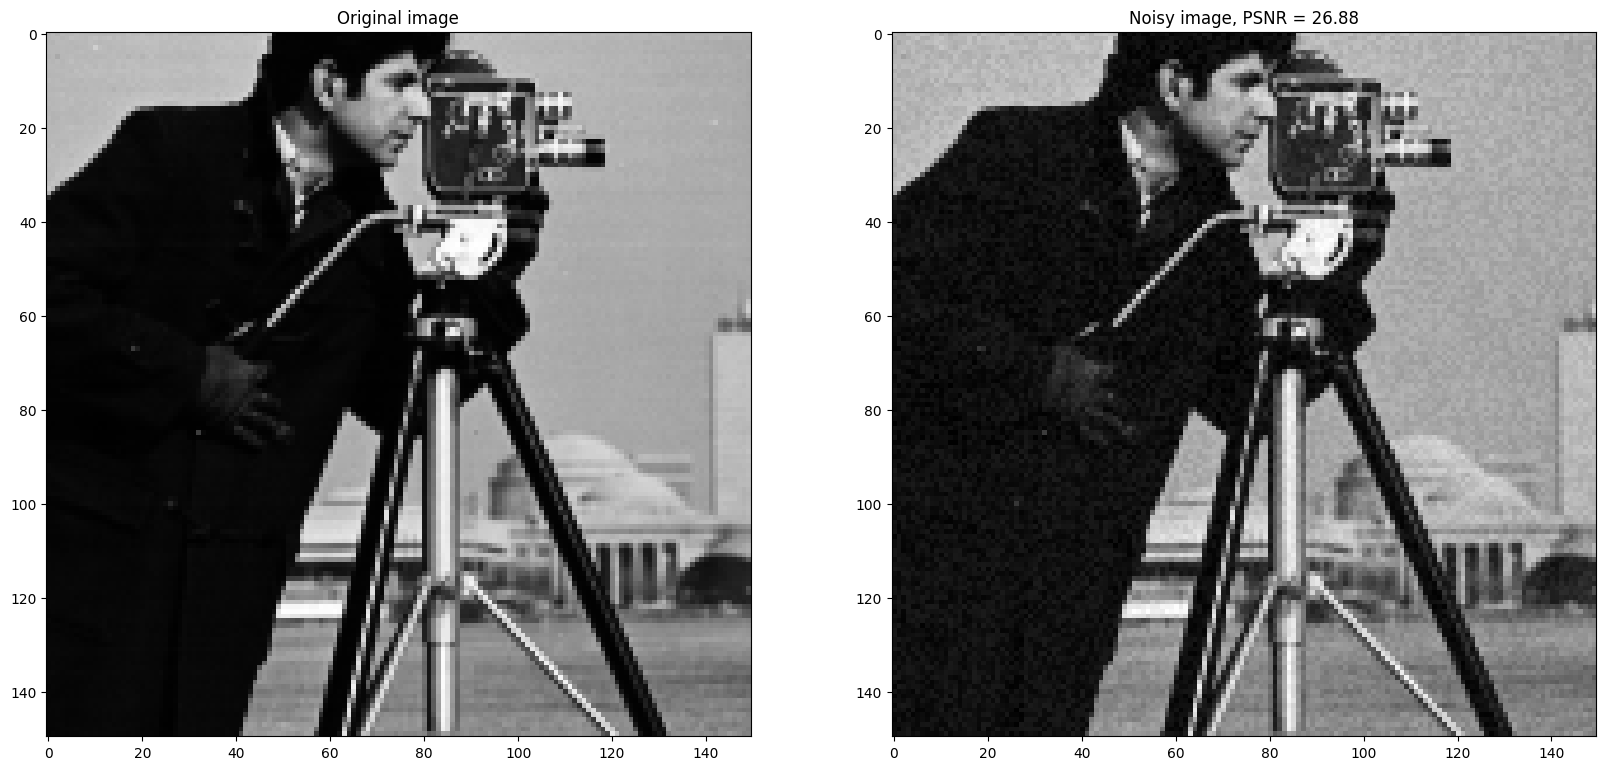

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Pixel-based NL-Means
--------------------
Set parameters and initialize the variables

In [90]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# pad the noisy image
pad_size = p // 2
img_pad = np.pad(img, pad_size)

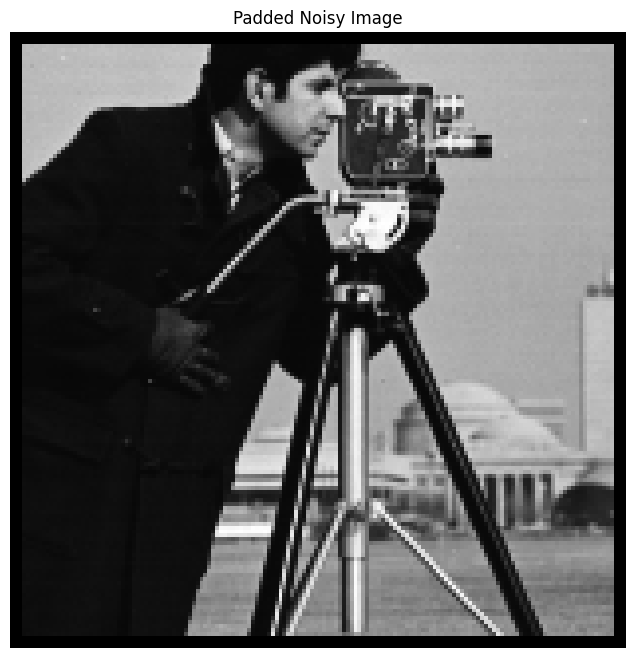

In [91]:
plt.figure(figsize=(8, 8))
plt.imshow(img_pad, cmap='gray')
plt.title('Padded Noisy Image')
plt.axis('off')
plt.show()

Main loop

In [92]:
h = 2 * sigma_noise
for i in range(0, imsz[0]):
    for j in range(0, imsz[1]):
        # extrach the patch from img_pad whose center has the location (i, j) in the noisy image
        s = img_pad[i : i + p, j : j + p].flatten()

        # initialize the pixel estimate and the total weights
        pixel_hat = 0
        weight = 0

        i_start = max(0, i - H)
        i_stop = min(imsz[0], i + H + 1)
        j_start = max(0, j - H)
        j_stop = min(imsz[1], j + H + 1)

        # extract all the patches in the search neighborhood
        for r in range(i_start, i_stop):
            for c in range(j_start, j_stop):
                # extract the patch
                z = img_pad[r : r + p, c : c + p].flatten()

                # compute the distance with the reference patch
                d = np.sum((s - z) ** 2)

                # compute weight
                w = np.exp(-d / (h**2))

                # update the weight and the pixel estimate
                pixel_hat += w * noisy_img[r, c]
                weight += w

        # estimate the pixel (i, j) as the weighted average of the central pixel of the extracted patches
        img_hat[i, j] = pixel_hat / max(weight, 1e-10)

Compute the PSNR of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 27.47')

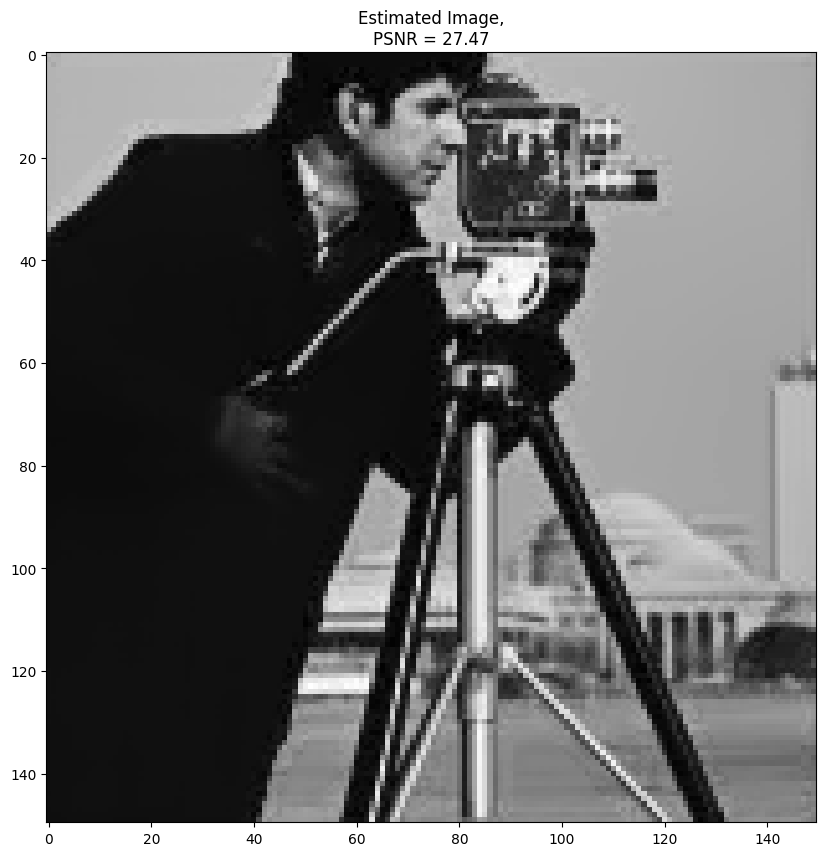

In [93]:
psnr_hat = psnr(img, img_hat)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
